# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [50]:
%pip install pyspark
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [227]:
import os
import pandas as pd
import pyspark as ps
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC

In [52]:
plt.rcParams["figure.figsize"] = (6, 5)

In [53]:
# create a spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is mini_sparkify_event_data.json. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [54]:
df = spark.read.json("Project-4/mini_sparkify_event_data.json")
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [55]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

*Small Notes: I do prefer visualize and EDA using pandas, it's seem easy to preview with built-in VScode function*

However, in the scope of practise with Spark, I will only use Pandas for cleaning and (later) use PySpark to do EDA.

In [56]:
df = pd.read_json('Project-4/mini_sparkify_event_data.json', lines=True)

In [57]:
df.describe()

,ts,sessionId,status,itemInSession,registration,length
count,2.865000e+05,286500.000000,286500.000000,286500.000000,2.781540e+05,228108.000000
mean,1.540957e+12,1041.526555,210.054597,114.414213,1.535359e+12,249.117182
std,1.507544e+09,726.776263,31.505078,129.767262,3.291322e+09,99.235179
min,1.538352e+12,1.000000,200.000000,0.000000,1.521381e+12,0.783220
25%,1.539697e+12,336.000000,200.000000,27.000000,1.533522e+12,199.888530
50%,1.540932e+12,1013.000000,200.000000,70.000000,1.536664e+12,234.500770
75%,1.542266e+12,1675.000000,200.000000,156.250000,1.537672e+12,277.158730
max,1.543799e+12,2474.000000,404.000000,1321.000000,1.543247e+12,3024.665670


In [58]:
df.isna().sum()

ts                   0
userId               0
sessionId            0
page                 0
auth                 0
method               0
status               0
level                0
itemInSession        0
location          8346
userAgent         8346
lastName          8346
firstName         8346
registration      8346
gender            8346
artist           58392
song             58392
length           58392
dtype: int64

In [59]:
# Count empty userId
len(df[df['userId'] == ''])

8346

In [60]:
# Clear instance with empty userId
df_clean = df[df.userId != '']

In [61]:
len(df[df['sessionId'] == ''])
# No NA value in sessionId

0

In [62]:
# Convert timestamp and registration to datetime
df['ts']

0         1538352117000
1         1538352180000
2         1538352394000
3         1538352416000
4         1538352676000
              ...      
286495    1543622240000
286496    1543622241000
286497    1543622248000
286498    1543622398000
286499    1543622411000
Name: ts, Length: 286500, dtype: int64

In [63]:
import datetime
def convert_ts(ts): 
    return datetime.datetime.fromtimestamp(ts / 1000.0).strftime("%Y-%m-%d %H:%M:%S")

df_clean['time'] = df_clean['ts'].apply(convert_ts)
df_clean['regis_time'] = df_clean['registration'].apply(convert_ts)

/tmp/ipykernel_10403/1372992459.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['time'] = df_clean['ts'].apply(convert_ts)
/tmp/ipykernel_10403/1372992459.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['regis_time'] = df_clean['registration'].apply(convert_ts)


In [64]:
df_clean['time'].describe()

count                  278154
unique                 269770
top       2018-10-06 00:35:40
freq                        4
Name: time, dtype: object

In [65]:
df_clean['regis_time'].describe()

count                  278154
unique                    225
top       2018-06-15 01:52:21
freq                     9632
Name: regis_time, dtype: object

In [66]:
# From current timestamp and registration date
# We can calculate the number of days since registration

def get_duration(x, y):
    return float((x-y)/(1000*60*60*24))

df_clean['joined_days'] = df_clean.apply(lambda x: get_duration(x['ts'], x['registration']), axis=1)

/tmp/ipykernel_10403/1680293738.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['joined_days'] = df_clean.apply(lambda x: get_duration(x['ts'], x['registration']), axis=1)


In [67]:
df_clean.to_json("mini_sparkify_clean.json", lines=True, orient='records')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

## Define Churn
Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.

## Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [68]:
df = spark.read.json("mini_sparkify_clean.json")
df.show(5)

+----------------+---------+---------+------+-------------+------------+--------+---------+-----+--------------------+------+--------+-------------------+--------------+---------+--------------------+------+-------------------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession| joined_days|lastName|   length|level|            location|method|    page|         regis_time|  registration|sessionId|                song|status|               time|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+------------+--------+---------+-----+--------------------+------+--------+-------------------+--------------+---------+--------------------+------+-------------------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50|2.0689236111| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|2018-09-28 22:22:42|1.538173362E12|       29|           

**Q1: How many users do we have in the dataset and how many of them have left the service?** (Cancel the subscription)

In [69]:
df.select('userId').dropDuplicates().count()

225

In [70]:
df.groupBy("page").count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



There are 225 users in total and 52 of them have canceled their subscription.

**Q2: Does the gender of the user have an impact on the churn rate?**

In [71]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

In [72]:
def churn_convert(example):
    return 1 if example == "Cancellation Confirmation" else 0

# df['churn'] = df['page'].apply(annotate_churn)
churn_convert_UDF = F.udf(lambda x: churn_convert(x), IntegerType())
df = df.withColumn("churn", churn_convert_UDF(col("page")))
df.show()

+--------------------+---------+---------+------+-------------+-------------+--------+---------+-----+--------------------+------+---------------+-------------------+--------------+---------+--------------------+------+-------------------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession|  joined_days|lastName|   length|level|            location|method|           page|         regis_time|  registration|sessionId|                song|status|               time|           ts|           userAgent|userId|churn|
+--------------------+---------+---------+------+-------------+-------------+--------+---------+-----+--------------------+------+---------------+-------------------+--------------+---------+--------------------+------+-------------------+-------------+--------------------+------+-----+
|      Martha Tilston|Logged In|    Colin|     M|           50| 2.0689236111| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|      

In [73]:
df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  225|
+-----+-----+



In [74]:
gender_df = df.select(['gender', 'userId', 'churn']).dropDuplicates().groupBy('gender', 'churn').count()
gender_df.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M|    1|   32|
|     F|    0|  104|
|     F|    1|   20|
|     M|    0|  121|
+------+-----+-----+



<Axes: xlabel='churn', ylabel='count'>

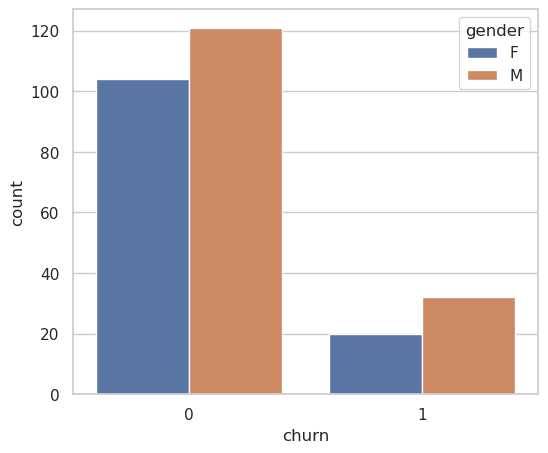

In [75]:
sns.set(style="whitegrid")
sns.barplot(x='churn', y='count', data=gender_df.toPandas(), hue='gender')

From the chart, the turnover rate of male users are higher than female users.
However, this might not indicate well the actual situation since the number of male users are more than female users.

I wonder if the user that churned have spent more time on the app than the user that not churned.

**Q3: How long do users spend on the app before they churn?**

array([[<Axes: title={'center': 'length'}>]], dtype=object)

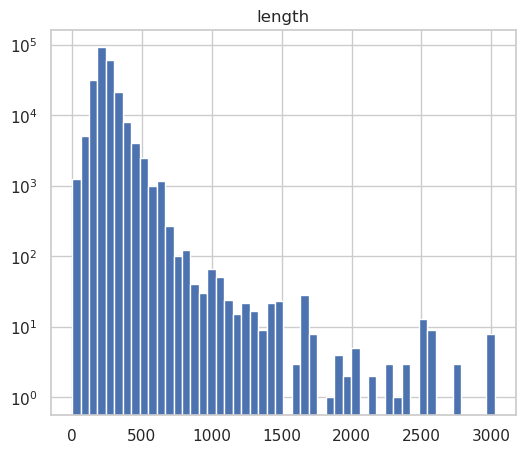

In [76]:
df.select(['length']).toPandas().dropna().hist(bins=50, log=True)

array([[<Axes: title={'center': 'itemInSession'}>]], dtype=object)

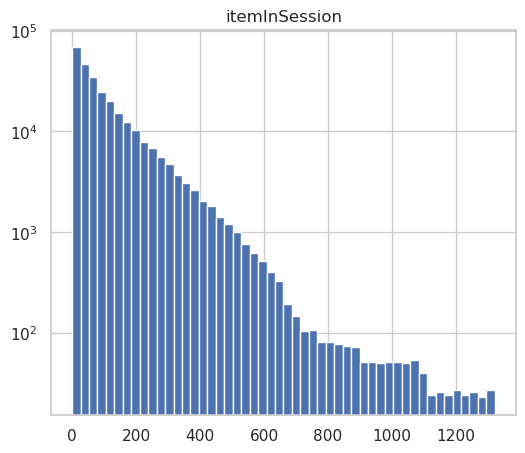

In [77]:
df.select(['itemInSession']).toPandas().dropna().hist(bins=50, log=True)

In [78]:
df.select(['itemInSession']).describe().show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|129.85172939949027|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [79]:
df.select(['joined_days']).describe().show()

+-------+-----------------+
|summary|      joined_days|
+-------+-----------------+
|  count|           278154|
|   mean|  64.815756322928|
| stddev|41.99336760534732|
|    min|    -2.2718171296|
|    max|   256.3776736111|
+-------+-----------------+



In [129]:
# However, joined_days contains duplicated userId with different timestamp, try to get the latest timestamp for each userId
from pyspark.sql import Window, types
from pyspark.sql.functions import dense_rank, desc
# Order by last timestamp
w = Window.partitionBy("userId").orderBy(desc("time"))
df = df.withColumn("time_rank", dense_rank().over(w))
df.show(5)

+----------+---------+---------+------+-------------+-------------+---------+---------+-----+--------------------+------+-----------+-------------------+-------------+---------+-------------------+------+-------------------+-------------+--------------------+------+-----+---+-------+--------+--------------+-------------+-----------+---------------+----------------+---------+
|    artist|     auth|firstName|gender|itemInSession|  joined_days| lastName|   length|level|            location|method|       page|         regis_time| registration|sessionId|               song|status|               time|           ts|           userAgent|userId|churn|day|browser|platform|gender_indexed|level_indexed|day_indexed|browser_indexed|platform_indexed|time_rank|
+----------+---------+---------+------+-------------+-------------+---------+---------+-----+--------------------+------+-----------+-------------------+-------------+---------+-------------------+------+-------------------+-------------+------

array([[<Axes: title={'center': 'joined_days'}>]], dtype=object)

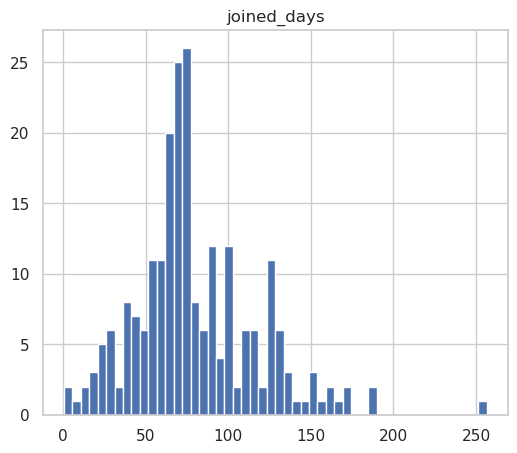

In [131]:
df.filter(df['time_rank'] == 1).select(['joined_days']).toPandas().dropna().hist(bins=50)

In [81]:
churn_day_count = df[df['churn'] == 1].select('joined_days').toPandas().dropna()
churn_day_count.head()

,joined_days
0,38.431991
1,21.590891
2,71.316887
3,29.607176
4,13.099016


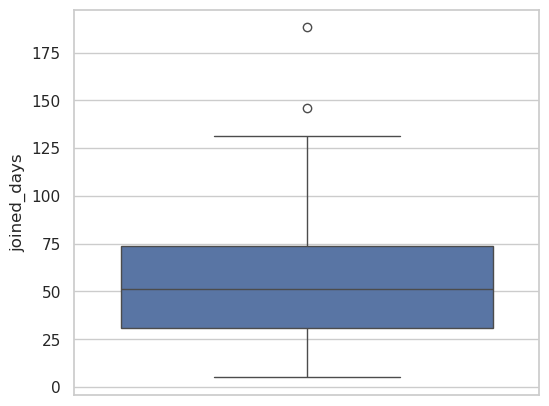

In [82]:
sns.boxplot(churn_day_count['joined_days']);

In [83]:
churn_day_count.describe()

,joined_days
count,52.000000
mean,57.305993
std,36.633148
min,5.165116
25%,30.801238
50%,51.289392
75%,73.751444
max,188.311782


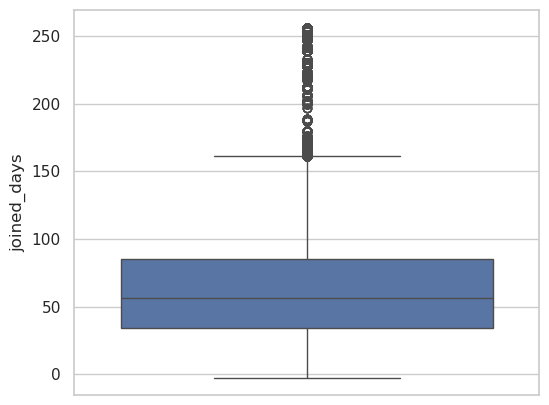

In [84]:
_churn_day_count = df[df['churn'] == 0].select('joined_days').toPandas().dropna()
sns.boxplot(_churn_day_count['joined_days']);

It seem like the users who churn are join for less time than the others. However, the difference is not significant.

Move on to analysis the data itself, I wonder if the weekdays effect users activity.

**Q4: Does weekday affect users activity?**

In [85]:
df = df.withColumn('day', F.date_format('time', 'E'))
df.show(5)

+----------------+---------+---------+------+-------------+------------+--------+---------+-----+--------------------+------+--------+-------------------+--------------+---------+--------------------+------+-------------------+-------------+--------------------+------+-----+---+
|          artist|     auth|firstName|gender|itemInSession| joined_days|lastName|   length|level|            location|method|    page|         regis_time|  registration|sessionId|                song|status|               time|           ts|           userAgent|userId|churn|day|
+----------------+---------+---------+------+-------------+------------+--------+---------+-----+--------------------+------+--------+-------------------+--------------+---------+--------------------+------+-------------------+-------------+--------------------+------+-----+---+
|  Martha Tilston|Logged In|    Colin|     M|           50|2.0689236111| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|2018-09-28 22:22:42|1.5381

<Axes: xlabel='day', ylabel='count'>

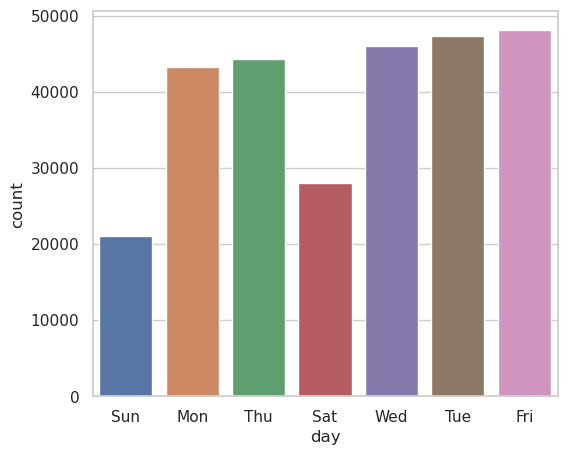

In [86]:
day_df = df.select('day').groupBy('day').count().toPandas()
sns.barplot(x='day', y='count', data=day_df, hue='day')

So it's clear that people are more active during the weekdays than the weekends, it might due to the fact weekdays are working days and people usually enjoy listening while working.

I see a field named "userAgent" with a noisy value but contain information of their device type and browser.

**Q5: What is the most common browser and device type?**

In [114]:
df[['userAgent']].distinct().collect()[:5]

[Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0')]

In [88]:
def _get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        return 'Chrome' if 'Chrome' in x else 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return None
    
def _get_platform(x):
    if 'Windows' in x:
        return 'Windows'
    elif 'Macintosh' in x:
        return 'Mac'
    elif 'iPhone' in x:
        return 'iPhone'
    elif 'iPad' in x:
        return 'iPad'
    else:
        return 'Linux'

get_browser = udf(lambda x : _get_browser(x))
get_platform = udf(lambda x : _get_platform(x))

<Axes: xlabel='browser', ylabel='count'>

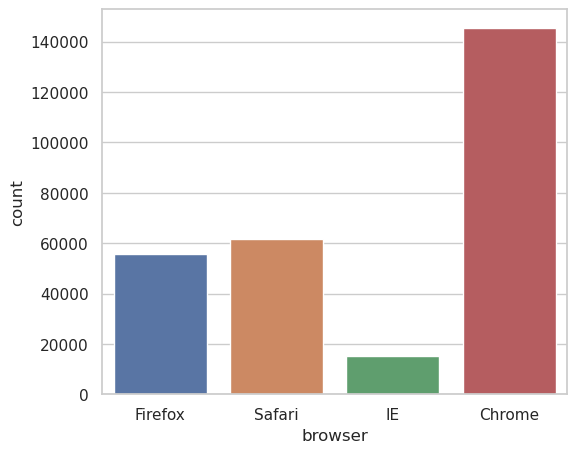

In [91]:
_browser_df = df.select('browser').groupBy('browser').count().toPandas()
sns.barplot(x='browser', y='count', data=_browser_df, hue='browser')

In [89]:
df = df.withColumn('browser', get_browser(df.userAgent))
df.show(5)

+----------------+---------+---------+------+-------------+------------+--------+---------+-----+--------------------+------+--------+-------------------+--------------+---------+--------------------+------+-------------------+-------------+--------------------+------+-----+---+-------+
|          artist|     auth|firstName|gender|itemInSession| joined_days|lastName|   length|level|            location|method|    page|         regis_time|  registration|sessionId|                song|status|               time|           ts|           userAgent|userId|churn|day|browser|
+----------------+---------+---------+------+-------------+------------+--------+---------+-----+--------------------+------+--------+-------------------+--------------+---------+--------------------+------+-------------------+-------------+--------------------+------+-----+---+-------+
|  Martha Tilston|Logged In|    Colin|     M|           50|2.0689236111| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|20

In [90]:
df = df.withColumn('platform', get_platform(df.userAgent))
df.show(5)

+----------------+---------+---------+------+-------------+------------+--------+---------+-----+--------------------+------+--------+-------------------+--------------+---------+--------------------+------+-------------------+-------------+--------------------+------+-----+---+-------+--------+
|          artist|     auth|firstName|gender|itemInSession| joined_days|lastName|   length|level|            location|method|    page|         regis_time|  registration|sessionId|                song|status|               time|           ts|           userAgent|userId|churn|day|browser|platform|
+----------------+---------+---------+------+-------------+------------+--------+---------+-----+--------------------+------+--------+-------------------+--------------+---------+--------------------+------+-------------------+-------------+--------------------+------+-----+---+-------+--------+
|  Martha Tilston|Logged In|    Colin|     M|           50|2.0689236111| Freeman|277.89016| paid|     Bakersf

<Axes: xlabel='platform', ylabel='count'>

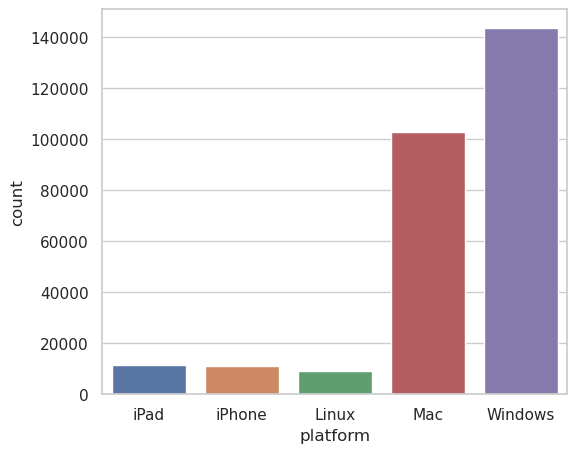

In [92]:
_platform_df = df.select('platform').groupBy('platform').count().toPandas()
sns.barplot(x='platform', y='count', data=_platform_df, hue='platform')

As indicated in the chart, the common browser for Sparkify users is Chrome and through Windows or Mac. However, there are a small number of users using iPad or iPhone, which mean the app is somewhat popular in mobile devices.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

Write a script to extract the necessary features from the smaller subset of data
Ensure that your script is scalable, using the best practices discussed in Lesson 3
Try your script on the full data set, debugging your script if necessary
If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

The feature I will build on:
- Categorical Features (need label encoding)
  - gender
  - level
  - browser
  - platform
- Numerical Features
  - joined_day: membership day
  - songs_played: number of songs played
  - songs_listened: number of song listened per session
  - usage_time: total of length (!= NULL)
  - artist_followed: number of artists listen to
  - total numbers of NextSong, ThumbsUp, ThumbsDown, AddtoPlaylist, AddFriend, RollAdvert

In [93]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- joined_days: double (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- regis_time: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- time: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- day: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- platform: string (nullable = true)



In [94]:
from pyspark.ml.feature import StringIndexer

In [95]:
def cat_transform(df, col_name):
    '''transform categorical items to number'''
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name+"_indexed")
    indexed = indexer.fit(df).transform(df)
    return indexed

In [ ]:
# get categorical features
categorical_feature = ["gender", "level", "day", "browser", "platform"]
for col in categorical_feature:
    df = cat_transform(df, col)

In [202]:
categorical_feature_names = ['gender_indexed', 'level_indexed', 'day_indexed', 'browser_indexed', 'platform_indexed']

In [190]:
f_categories = df.select(["userId", "gender_indexed", "level_indexed", "day_indexed", "browser_indexed", "platform_indexed"]).groupBy(["userId"]).\
    agg(F.max("gender_indexed").alias("gender_indexed"), \
        F.max("level_indexed").alias("level_indexed"), \
        F.max("day_indexed").alias("day_indexed"), \
        F.max("browser_indexed").alias("browser_indexed"), \
        F.max("platform_indexed").alias("platform_indexed"))
f_categories.show()

+------+--------------+-------------+-----------+---------------+----------------+
|userId|gender_indexed|level_indexed|day_indexed|browser_indexed|platform_indexed|
+------+--------------+-------------+-----------+---------------+----------------+
|    51|           1.0|          0.0|        6.0|            0.0|             0.0|
|   124|           0.0|          0.0|        6.0|            0.0|             1.0|
|     7|           1.0|          1.0|        3.0|            2.0|             0.0|
|    54|           0.0|          1.0|        6.0|            2.0|             0.0|
|    15|           1.0|          0.0|        6.0|            0.0|             0.0|
|   132|           0.0|          1.0|        6.0|            1.0|             1.0|
|   101|           1.0|          1.0|        6.0|            2.0|             0.0|
|    11|           0.0|          1.0|        6.0|            3.0|             0.0|
|   138|           1.0|          1.0|        6.0|            1.0|             2.0|
|   

In [100]:
df.show(5)

+----------------+---------+---------+------+-------------+------------+--------+---------+-----+--------------------+------+--------+-------------------+--------------+---------+--------------------+------+-------------------+-------------+--------------------+------+-----+---+-------+--------+--------------+-------------+-----------+---------------+----------------+
|          artist|     auth|firstName|gender|itemInSession| joined_days|lastName|   length|level|            location|method|    page|         regis_time|  registration|sessionId|                song|status|               time|           ts|           userAgent|userId|churn|day|browser|platform|gender_indexed|level_indexed|day_indexed|browser_indexed|platform_indexed|
+----------------+---------+---------+------+-------------+------------+--------+---------+-----+--------------------+------+--------+-------------------+--------------+---------+--------------------+------+-------------------+-------------+-----------------

In [ ]:
from pyspark.sql.functions import first, min, max, avg, sum

In [184]:
f_song_played = df.select(["userId","song"]).groupBy("userId").count()
# f_song_played.show(5)
f_song_played = f_song_played.withColumnRenamed("count","song_played")

In [ ]:
# f_song_listened = df.select(["userId","song"]).drop_duplicates(["userId", "song"]).groupby(["userId"]).count()
f_song_listened = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()
f_song_listened = f_song_listened.groupBy('userId').agg(F.sum("count").alias("song_listened"))
# f_song_listened = f_song_listened.withColumnRenamed("count","song_listened")

225

In [159]:
f_followed_artist = df.select(["userId", "artist"]).dropDuplicates(["userId","artist"]).groupby(["userId"]).count()
f_followed_artist = f_followed_artist.withColumnRenamed("count", "followed_artist")

In [133]:
f_joined_day = df.filter(df['time_rank'] == 1).select(['userId', 'joined_days'])

In [141]:
f_length = df.select(["userId", "length"]).groupby(["userId"]).agg(
    avg('length').alias('avg_length'), 
    max('length').alias('max_length'),
    min('length').alias('min_length'))

In [153]:
def get_action(df, action):
    event = F.udf(lambda x: 1 if x == action else 0, IntegerType())
    temp_df = df.withColumn("temp", event("page"))
    return temp_df.groupBy("userId").agg(F.sum("temp").alias(f"{str(action).lower().replace(' ', '_')}_count"))

events = 'NextSong','Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Roll Advert'
f_event = df.select("userId").distinct()
for event in events:
    temp = get_action(df, event)
    temp.show(5)
    f_event = f_event.join(temp, on='userId', how='left')

+------+--------------+
|userId|nextsong_count|
+------+--------------+
|    51|          2111|
|   124|          4079|
|     7|           150|
|    54|          2841|
|    15|          1914|
+------+--------------+
only showing top 5 rows

+------+---------------+
|userId|thumbs_up_count|
+------+---------------+
|    51|            100|
|   124|            171|
|     7|              7|
|    54|            163|
|    15|             81|
+------+---------------+
only showing top 5 rows

+------+-----------------+
|userId|thumbs_down_count|
+------+-----------------+
|    51|               21|
|   124|               41|
|     7|                1|
|    54|               29|
|    15|               14|
+------+-----------------+
only showing top 5 rows

+------+---------------------+
|userId|add_to_playlist_count|
+------+---------------------+
|    51|                   52|
|   124|                  118|
|     7|                    5|
|    54|                   72|
|    15|                

In [191]:
data = f_length.join(f_event,on='userId',how='inner').\
                    join(f_followed_artist,on='userId',how='inner').\
                    join(f_joined_day,on='userId',how='inner').\
                    join(f_song_listened,on='userId',how='inner').\
                    join(f_song_played,on='userId',how='inner').\
                    join(f_categories,on='userId',how='inner')

In [192]:
data.show(5)

+------+------------------+----------+----------+--------------+---------------+-----------------+---------------------+----------------+-----------------+---------------+--------------+-------------+-----------+--------------+-------------+-----------+---------------+----------------+
|userId|        avg_length|max_length|min_length|nextsong_count|thumbs_up_count|thumbs_down_count|add_to_playlist_count|add_friend_count|roll_advert_count|followed_artist|   joined_days|song_listened|song_played|gender_indexed|level_indexed|day_indexed|browser_indexed|platform_indexed|
+------+------------------+----------+----------+--------------+---------------+-----------------+---------------------+----------------+-----------------+---------------+--------------+-------------+-----------+--------------+-------------+-----------+---------------+----------------+
|    51| 247.8805508289911|2594.87302|   4.04853|          2111|            100|               21|                   52|              28|  

In [193]:
labels = df.select(['userId','Churn']).dropDuplicates()

In [195]:
data = data.join(labels, on=['userId'], how='inner')
data.show(5)

+------+------------------+----------+----------+--------------+---------------+-----------------+---------------------+----------------+-----------------+---------------+--------------+-------------+-----------+--------------+-------------+-----------+---------------+----------------+-----+
|userId|        avg_length|max_length|min_length|nextsong_count|thumbs_up_count|thumbs_down_count|add_to_playlist_count|add_friend_count|roll_advert_count|followed_artist|   joined_days|song_listened|song_played|gender_indexed|level_indexed|day_indexed|browser_indexed|platform_indexed|Churn|
+------+------------------+----------+----------+--------------+---------------+-----------------+---------------------+----------------+-----------------+---------------+--------------+-------------+-----------+--------------+-------------+-----------+---------------+----------------+-----+
|    51| 247.8805508289911|2594.87302|   4.04853|          2111|            100|               21|                   52| 

In [ ]:
# Normalize 
vector = VectorAssembler(inputCols=categorical_feature_names, 
                         outputCol='numerical_features')
transform_fn = vector.transform(data)
scaler = StandardScaler(withMean=True, withStd=True, 
                        inputCol='numerical_features', 
                        outputCol='features_scaled')
_data = scaler.fit(transform_fn).transform(transform_fn)

In [205]:
vector = VectorAssembler(inputCols=categorical_feature_names + ['features_scaled'], outputCol='features')
final_data = vector.transform(_data)

In [206]:
final_data = final_data.select([final_data.Churn.alias('label'), 'features'])
final_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[1.0,0.0,6.0,0.0,...|
|    0|[1.0,0.0,6.0,0.0,...|
|    0|[0.0,0.0,6.0,0.0,...|
|    0|[1.0,1.0,3.0,2.0,...|
|    1|[0.0,1.0,6.0,2.0,...|
|    0|[0.0,1.0,6.0,2.0,...|
|    0|[1.0,0.0,6.0,0.0,...|
|    0|[0.0,1.0,6.0,1.0,...|
|    1|[1.0,1.0,6.0,2.0,...|
|    0|[1.0,1.0,6.0,2.0,...|
|    0|[0.0,1.0,6.0,3.0,...|
|    0|[1.0,1.0,6.0,1.0,...|
|    1|[1.0,1.0,6.0,1.0,...|
|    0|[1.0,1.0,6.0,1.0,...|
|    0|[0.0,1.0,6.0,0.0,...|
|    0|[0.0,1.0,6.0,0.0,...|
|    0|[1.0,1.0,6.0,2.0,...|
|    1|[1.0,1.0,6.0,0.0,...|
|    0|[1.0,1.0,6.0,0.0,...|
|    1|[0.0,1.0,3.0,2.0,...|
+-----+--------------------+
only showing top 20 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [213]:
train, test = final_data.randomSplit([0.8,0.2], seed=42)

In [214]:
print("#training sample", train.count())
# print("#validation sample", dev.count())
print("#testing sample", test.count())

#training sample 238
#testing sample 42


In [221]:
# Initialize models
lr = LogisticRegression(maxIter=50)

rf = RandomForestClassifier(seed=10) 

dt = DecisionTreeClassifier(seed=42)

svm = LinearSVC()

In [212]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [220]:
def train_and_evaluate(clf, train, test):
    '''Train and evaluate the model'''
    print('='*50)
    print(f'Start training {clf.__class__.__name__}')
    model = clf.fit(train)
    pred_test = model.transform(test)

    #metrics
    precision = evaluator.evaluate(pred_test.select('label','prediction'), {evaluator.metricName: 'precisionByLabel'})
    recall = evaluator.evaluate(pred_test.select('label','prediction'), {evaluator.metricName: 'recallByLabel'})
    acc = evaluator.evaluate(pred_test.select('label','prediction'), {evaluator.metricName: 'accuracy'})
    f1 = evaluator.evaluate(pred_test.select('label','prediction'), {evaluator.metricName: 'f1'})
    print(f'{clf.__class__.__name__}')
    print('Accuracy:', acc)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)

    return dict(name=clf.__class__.__name__, f1=f1, precision=precision, recall=recall, accuracy=acc)

In [222]:
res = []
for model in [lr, rf, dt, svm]:
    res.append(train_and_evaluate(model, train, test))

Start training LogisticRegression
LogisticRegression
Accuracy: 0.8333333333333334
Precision: 0.8333333333333334
Recall: 1.0
F1: 0.7575757575757576
Start training RandomForestClassifier
RandomForestClassifier
Accuracy: 0.8095238095238095
Precision: 0.8292682926829268
Recall: 0.9714285714285714
F1: 0.7456140350877194
Start training DecisionTreeClassifier
DecisionTreeClassifier
Accuracy: 0.7857142857142857
Precision: 0.825
Recall: 0.9428571428571428
F1: 0.7333333333333334
Start training LinearSVC
LinearSVC
Accuracy: 0.8333333333333334
Precision: 0.8333333333333334
Recall: 1.0
F1: 0.7575757575757576


In [235]:
res_df = pd.DataFrame.from_records(res)
res_df

,name,f1,precision,recall,accuracy
0,LogisticRegression,0.757576,0.833333,1.000000,0.833333
1,RandomForestClassifier,0.745614,0.829268,0.971429,0.809524
2,DecisionTreeClassifier,0.733333,0.825000,0.942857,0.785714
3,LinearSVC,0.757576,0.833333,1.000000,0.833333


Tuning model

In [226]:
print(svm.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
maxBlockSizeInMB: maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0. (default: 0.0)
maxIter: max number of iterations (>= 0). (default: 100)
predictionCol: prediction column name. (default: prediction)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
regParam: regularization parameter (>= 0). (default: 0.0)
standardization: whether to standardize the training features before fitting the model. (default: True)
threshold: The threshold in binary classification applied to the linear model predictio

In [ ]:
param_grid = ParamGridBuilder() \
    .addGrid(svm.aggregationDepth,[2, 4, 6]) \
    .addGrid(svm.maxIter,[100, 150, 200]) \
    .build()


cv_fn = CrossValidator(estimator=svm, estimatorParamMaps=param_grid, numFolds=3,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"))

In [231]:
%%time
cv_svm = cv_fn.fit(train, )

CPU times: user 2.41 s, sys: 828 ms, total: 3.24 s
Wall time: 3min 53s


In [ ]:
pred_test = cv_svm.transform(test)
precision = evaluator.evaluate(pred_test.select('label','prediction'), {evaluator.metricName: 'precisionByLabel'})
recall = evaluator.evaluate(pred_test.select('label','prediction'), {evaluator.metricName: 'recallByLabel'})
acc = evaluator.evaluate(pred_test.select('label','prediction'), {evaluator.metricName: 'accuracy'})
f1 = evaluator.evaluate(pred_test.select('label','prediction'), {evaluator.metricName: 'f1'})


In [241]:
res_df.loc[len(res_df.index)] = ["SVM (cv)", f1, precision, recall, acc]
res_df

,name,f1,precision,recall,accuracy
0,LogisticRegression,0.757576,0.833333,1.000000,0.833333
1,RandomForestClassifier,0.745614,0.829268,0.971429,0.809524
2,DecisionTreeClassifier,0.733333,0.825000,0.942857,0.785714
3,LinearSVC,0.757576,0.833333,1.000000,0.833333
4,SVM (cv),0.757576,0.833333,1.000000,0.833333


# Conclusion

As we can see in the result dataframe, with a high quality data, the logistic regression can be compariable with linear SVC (which achieve same f1 score and accuracy).

# Final Steps

Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
%jupyter nbconvert --to html notebook.ipynb